In [1]:
using Pkg
Pkg.activate("C:/Users/ibzja/Documents/UPF_2022_2026/4t/2n_trimestre/Practiques_tutelades/CellBasedModels.jl")
using CellBasedModels 
using GeometryBasics
using Distributions
using GLMakie
Makie.inline!(true)

  Activating project at `C:\Users\ibzja\Documents\UPF_2022_2026\4t\2n_trimestre\Practiques_tutelades\CellBasedModels.jl`


true

In [2]:
function plotRods2D!(ax, x, y, d, l, angle; kargs...)

    Main.meshscatter!(ax,
                x.+l./2 .*cos.(angle),
                y.+l./2 .*sin.(angle),
                marker=Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )

    Main.meshscatter!(ax,
                x.-l./2 .*cos.(angle),
                y.-l./2 .*sin.(angle),
                marker=Sphere(Point3f(0,0,0),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=[Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(l,d)],
                rotation=angle,
                kargs...
            )

    return

end

function plotRods2D!(ax, x, y, xs1, ys1, xs2, ys2, markerSphere, markerCylinder, angle; kargs...)

    m = meshscatter!(ax,
                xs1,
                ys1,
                marker=Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=markerSphere;
                kargs...
            )

    Main.meshscatter!(ax,
                xs2,
                ys2,
                marker=Sphere(Point3f(0,0,0),Float32(1)),
                markersize=markerSphere;
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=markerCylinder,
                rotation=angle;
                kargs...
            )

    return m

end

plotRods2D! (generic function with 2 methods)

In [ ]:
rods2DChemotaxis = ABM(2,
    agent = Dict(
        :vx => Float64,
        :vy => Float64,
        :v => Float64,  #Swimming speed
        :theta => Float64,
        :d => Float64,
        :l => Float64,
        :m => Float64,
        :fx => Float64,
        :fy => Float64,
        :W => Float64,
        :pressure => Float64,
        :active => Bool,

        :methyl => Float64, #Receptor methylation
        :Yp => Float64, #CheYP levels, probability of tumblingç
        :G => Float64,
        :λ => Float64,
        :P => Float64,
        :M => Float64,
        :mm => Float64,
        :F => Float64

    ),

    model = Dict(

        :Dr_run => Float64,

        :ε0 => Float64, #Energy parameters
        :ε1 => Float64,
        :ε2 => Float64,
        :ε3 => Float64,
        :K => Float64,
        :Nrec => Float64, #Cooperativity
        :Ki => Float64, #Dissociation constants
        :Ka => Float64,
        :τm => Float64, #Methylation adaptation timescale
        :Yp0 => Float64,   #CheYP adapted
        :α => Float64,      #Gain in thesignaling pathway - from receptor to CheYP 
        :ωFrec => Float64,     #Basal switching frequency
    ),

    # medium = Dict(
    #     :mm => Float64
    # ),

    agentODE = quote

        mm = 0.02*exp((x - com.simBox[1,1])*3*30^(-1))
        
        # mm = 0.02*exp((x - com.simBox[1,1])*3*30^(-3 ))

        F = ε0 + ε1 * methyl + Nrec * log((1 + mm / Ki) / (1 + mm / Ka)) #Equació del paper per definir activitat del receptor
        F0 = log(α / K) - 1         #Energia lliure en estat adaptat

        mx = (ε0 + Nrec * log((1 + mm / Ki) / (1 + mm / Ka)) - F0) / (- ε1)

        Yp = α / (1 + exp(F))    
        G = ε2 / 4 - (ε3 / 2) / (1 + (K / Yp))      #CheYp segons activitat receptor

        dt(x) = active * vx  #Change position acording to constant speed afected by forces
        dt(y) = active * vy  
        dt(methyl) = -(1 / τm) * (methyl - mx)        #Methylation
        
    end,

    agentRule = quote


        if active 
            λ = ωFrec*exp(-G)*dt 
            P = 1 - exp(-λ * dt)
            
        else
            λ = ωFrec*exp(G)*dt 
            P = 1 - exp(-λ * dt)  
            
        end


        if active 
            λrt = ωFrec*exp(-G)*dt 
            P_rt = 1 - exp(-λrt * dt)
            P = rand() 
            # if P < λrt               #Si rate alta = mes probabilitat de canvi. Per tant, si random number mes petit =  canvi. 
            if P < P_rt             #Si rate alta = mes probabilitat de canvi. Per tant, si random number mes petit =  canvi. 
                active = false
                vx = 0
                vy = 0
                theta = rand(Uniform(0, 2π))            #Tumble = random reorientation
            else     #Si rate baixa 
                active = true
                vx = v * cos(theta)
                vy = v * sin(theta)
                theta += sqrt(2 * Dr_run * dt) * randn()        #Keep running, reorientation according to rotational difusion
            end

        elseif !active
            λtr = ωFrec*exp(G) *dt
            P_tr = 1 - exp(-λtr * dt)
            P = rand()
            # if P < λtr 
            if P < P_tr
                active = true
                vx = v * cos(theta)
                vy = v * sin(theta)
                theta += sqrt(2 * Dr_run * dt) * randn()
            else
                active = false
                vx = 0
                vy = 0
                theta = rand(Uniform(0, 2π))
            end
            
        end
 
        # if x < simBox[1,1]
        #     x = simBox[1,1]
        #     theta = pi - theta      #Avoid stuck in wall
        # elseif x > simBox[1,2]
        #     x = simBox[1,2]
        #     theta = pi - theta
        # end
        # if y < simBox[2,1]
        #     y = simBox[2,1]
        #     theta = -theta
        # elseif y > simBox[2,2]
        #     y = simBox[2,2]
        #     theta = -theta
        # end

    end,

    # mediumODE = quote
    #     if @mediumInside()
    #         dt(mm) = 0.02*exp((x - com.simBox[1,1])*30^(-3 ))
    #     end
    # end,

    neighborsAlg = CBMNeighbors.CellLinked(cellEdge = 4)
)

PARAMETERS
	x (Float64 agent)
	y (Float64 agent)
	M (Float64 agent)
	d (Float64 agent)
	active (Bool agent)
	v (Float64 agent)
	λ (Float64 agent)
	F (Float64 agent)
	fx (Float64 agent)
	mm (Float64 agent)
	methyl (Float64 agent)
	vx (Float64 agent)
	l (Float64 agent)
	m (Float64 agent)
	fy (Float64 agent)
	Yp (Float64 agent)
	P (Float64 agent)
	pressure (Float64 agent)
	vy (Float64 agent)
	W (Float64 agent)
	G (Float64 agent)
	theta (Float64 agent)
	ε1 (Float64 model)
	α (Float64 model)
	Dr_run (Float64 model)
	Ka (Float64 model)
	ε3 (Float64 model)
	ε0 (Float64 model)
	K (Float64 model)
	ε2 (Float64 model)
	Nrec (Float64 model)
	Yp0 (Float64 model)
	τm (Float64 model)
	Ki (Float64 model)
	ωFrec (Float64 model)


UPDATE RULES
agentRule
 begin
    if active
        λ__ = ωFrec * exp(-G) * dt
        P__ = 1 - exp(-λ * dt)
    else
        λ__ = ωFrec * exp(G) * dt
        P__ = 1 - exp(-λ * dt)
    end
    if active
        λrt = ωFrec * exp(-G) * dt
        P_rt = 1 - exp(-λrt * dt)
  

In [ ]:
com = Community(
    rods2DChemotaxis,
    N=20,
    dt=0.1,
    simBox=[-20 20; -20 20.],  #change box
    NMedium=[200, 200],
)

m = 1/100
g = 1/10000
d = 1

# com.kn = 2E6      * (m*g/d)
# com.γn = 2.2E2    * sqrt(g/d)
# com.γt = 2.2E2    * sqrt(g/d)
# com.μcc = 0.1
# com.μcw = 0.8
# com.β = 0.8
# com.βω = 0.8
# com.fChem = 1.0
com.Dr_run = 0.062

com.v = 20.0

com.ωFrec = 1.3
com.Ki = 0.0182
com.Ka = 3.0
com.Nrec = 6.0
com.ε0   = 6.0
com.ε1   = -1.0
com.ε2   = 80
com.ε3   = 80
# com.τm = 30.0
com.τm = 5.0
com.α   = 6.0
com.Yp0 = 3.0  
com.Yp0 = 2.0  
com.K = 3.0 

# com.ωTumble = 1
# com.DMedium = 0.00
# com.DSource = 0.07

com.m = 1.        
com.d = 1.        
com.l = 3;

# com.x = rand(Uniform(com.simBox[1,:]...),com.N)
com.x = -20
com.y = rand(Uniform(com.simBox[2,:]...),com.N)
com.theta = rand(Uniform(0,2π),com.N)

com.methyl .= 0.0
com.Yp .= com.Yp0

com.active = true

Nx, Ny = com.NMedium        #Added test for fixed gradient background
xvals = range(com.simBox[1,1], com.simBox[1,2], length = Nx)

# for i in 1:Nx, j in 1:Ny
#     com.mm[i, j] = 0.1 + 0.05 * (xvals[i] - com.simBox[1,1])
#     # com.mm[i, j] =  0.2*exp((xvals[i] - com.simBox[1,1])*3*30^(-3 ))
# end

-20.0:0.20100502512562815:20.0

Trajectory1 = com estava<br>
2 = afegint M i P per veure que passa<br>
3 = canviat a P per fer el switch, incrementat concentracio atractant<br>
totes ses cèl·lules tenen la mateixa mm (concentracio, es igual la x) <br>
7 = P per canvi, canviat equacions a les de Justin (part 1) <br>
8 = adaptation time 5.0<br>
9 = Yp0 --> 2.0


In [24]:
using CSV, DataFrames

outfile = "trajectory8.csv"
data = DataFrame(
    step = Int[],
    id = Int[],
    x = Float64[],
    y = Float64[],
    active = Bool[],
    λ = Float64[],
    G = Float64[], 
    P = Float64[],
    M = Float64[],   
    Yp = Float64[],
    methyl = Float64[],
    F = Float64[]
)



steps = 1000
loadToPlatform!(com, preallocateAgents=20)       #Preallocate agents = number of agents in community


for step in 1:steps
    step!(com)
    for i in 1:com.N
        push!(data, (
            step, 
            i,
            com.x[i],
            com.y[i],
            com.active[i],
            com.λ[i],
            com.G[i],
            com.P[i],
            com.mm[i],
            com.Yp[i],
            com.methyl[i],
            com.F[i]
        ))
    end
end

CSV.write(outfile, data)

"trajectory8.csv"

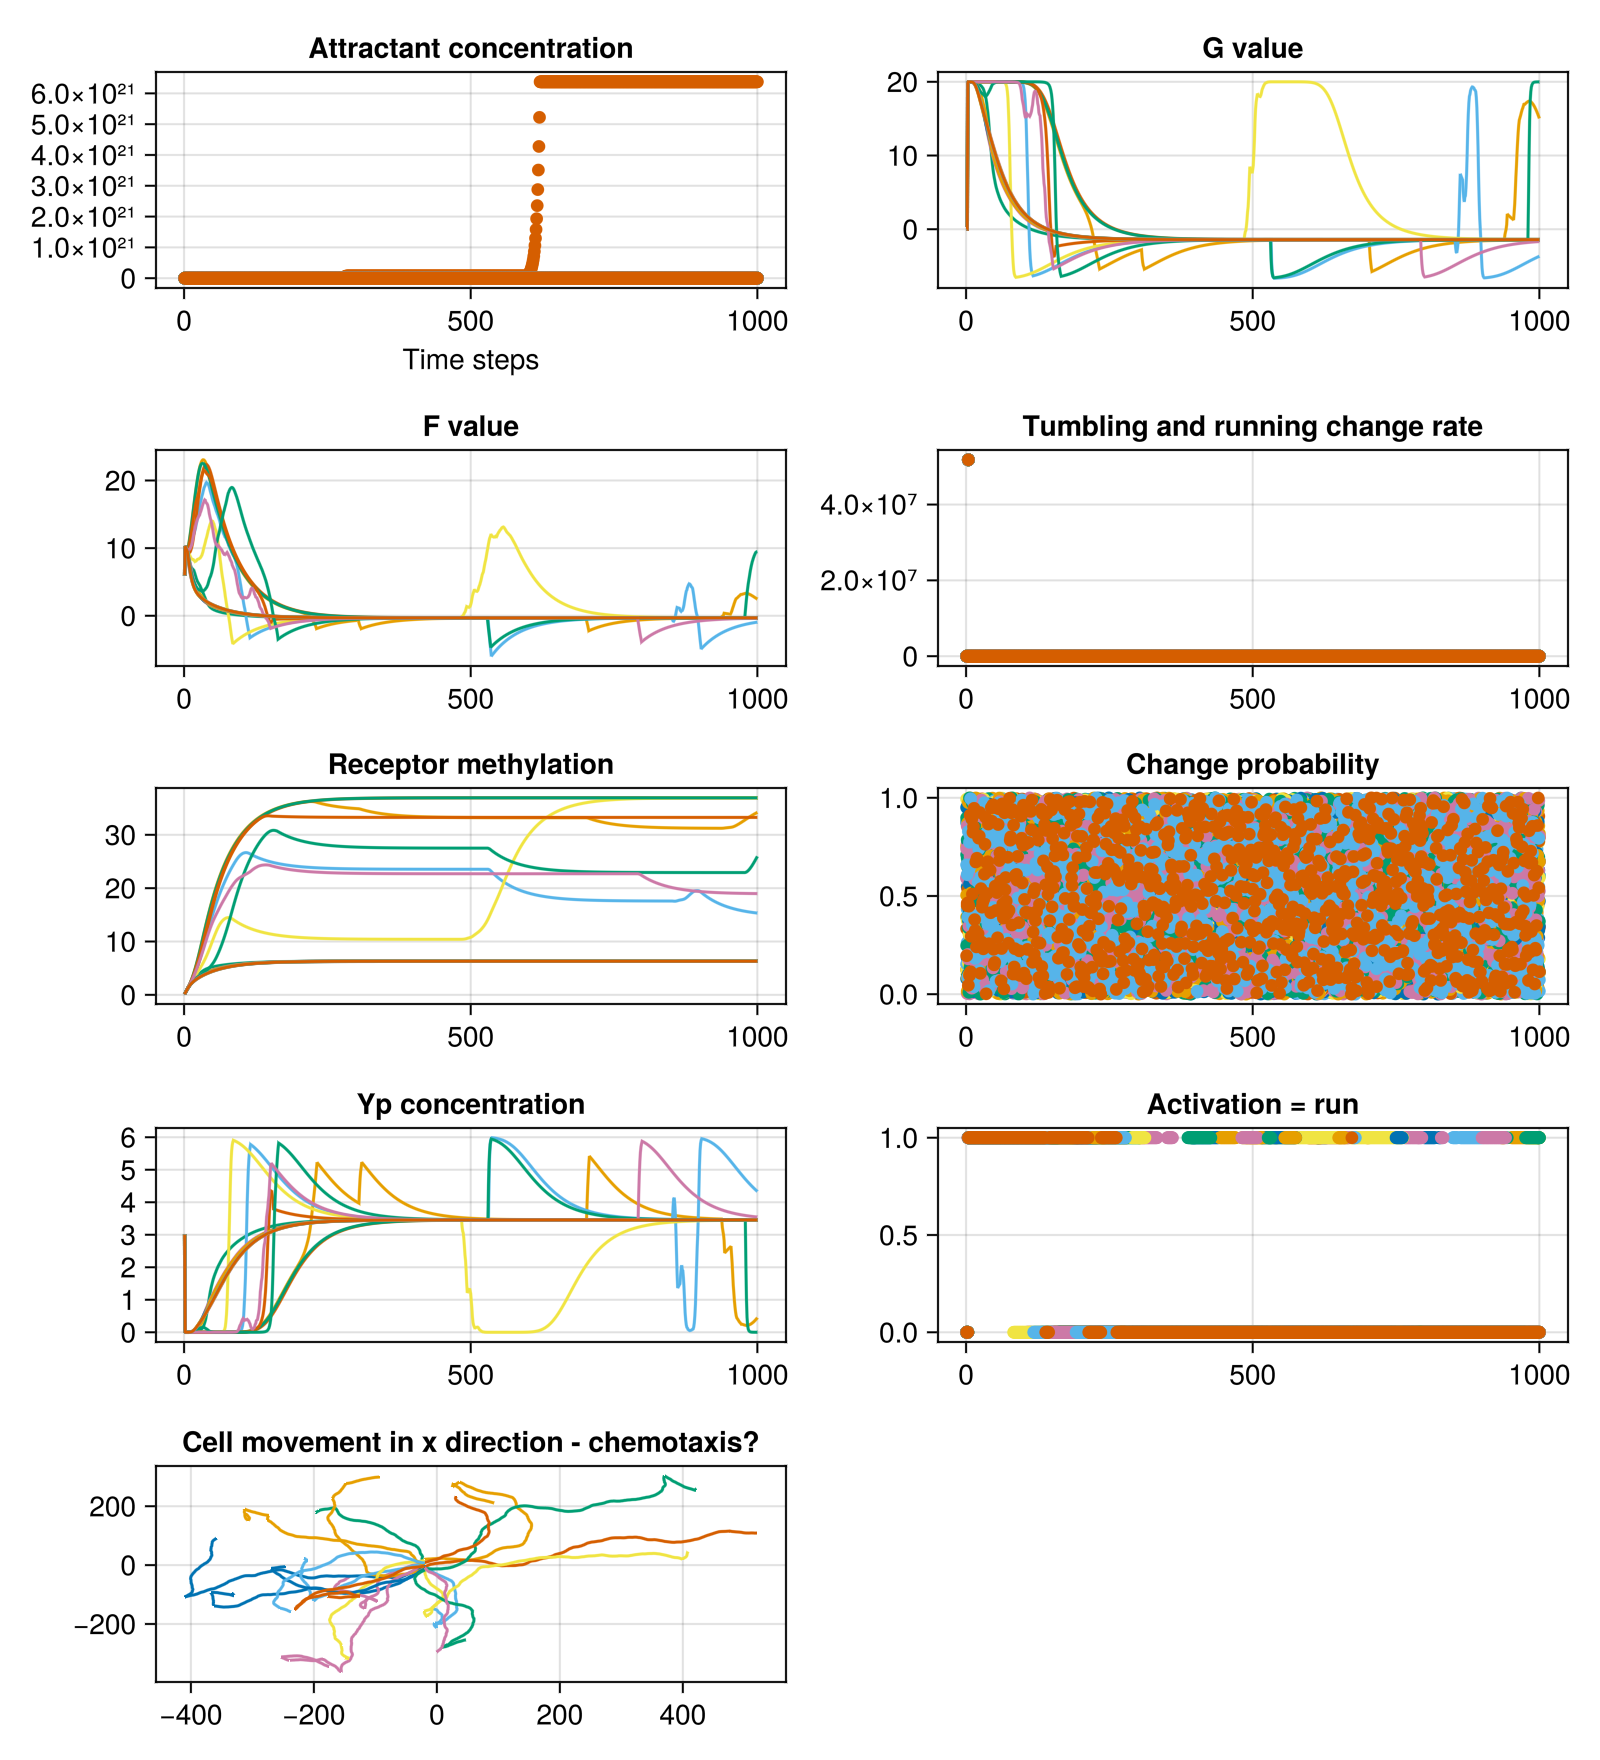

GLMakie.Screen(...)

In [25]:
fig = Figure(size = (800, 2800))

ax0 = Axis(fig[1,1], title = "Attractant concentration", xlabel = "Time steps")

for (id, group) in pairs(groupby(data, :id))
    scatter!(ax0, group.step, group.M, label = "Cell $id")
end

ax1 = Axis(fig[2,1], title = "F value" )

for (id, group) in pairs(groupby(data, :id))
    lines!(ax1, group.step, group.F, label = "Cell $id")
end


ax2 = Axis(fig[3,1], title = "Receptor methylation")

for (id, group) in pairs(groupby(data, :id))
    lines!(ax2, group.step, group.methyl, label = "Cell $id")
end

ax3 = Axis(fig[4,1], title = "Yp concentration")

for (id, group) in pairs(groupby(data, :id))
    lines!(ax3, group.step, group.Yp, label = "Cell $id")
end

ax4 = Axis(fig[1,2], title = "G value")

for (id, group) in pairs(groupby(data, :id))
    lines!(ax4, group.step, group.G, label = "Cell $id")
end

ax5 = Axis(fig[2,2], title = "Tumbling and running change rate")

for (id, group) in pairs(groupby(data, :id))
    scatter!(ax5, group.step, group.λ, label = "Cell $id")
end

ax6 = Axis(fig[3,2], title = "Change probability")

for (id, group) in pairs(groupby(data, :id))
    scatter!(ax6, group.step, group.P, label = "Cell $id")
end

ax6 = Axis(fig[4,2], title = "Activation = run")

for (id, group) in pairs(groupby(data, :id))
    scatter!(ax6, group.step, group.active, label = "Cell $id")
end

ax7 = Axis(fig[5,1], title = "Cell movement in x direction - chemotaxis?")

for (id, group) in pairs(groupby(data, :id))
    lines!(ax7, group.x, group.y, label = "Cell $id")
end





# axislegend(ax, position = :rt)

display(fig)

In [21]:
save("test9.png", fig)

In [ ]:
data_gr = groupby(data, :id)

cell1 = data_gr[1]
cell2 = data_gr[2]
cell3 = data_gr[3]
cell4 = data_gr[4]
cell5 = data_gr[5]
cell6 = data_gr[6]
cell7 = data_gr[7]

Row,step,id,x,y,active,λ,G,P,M,Yp,methyl
,Int64,Int64,Float64,Float64,Bool,Float64,Float64,Float64,Float64,Float64,Float64
1,1,7,19.9344,-5.17892,false,0.13,0.0,0.591532,1.08482,0.0148357,0.0210228
2,2,7,19.9344,-5.17892,false,0.13,19.8032,0.199074,1.08482,1.95324e-12,0.11789
3,3,7,19.9344,-5.17892,true,5.18022e7,20.0,0.289425,1.08482,2.15191e-12,0.214434
4,4,7,21.1493,-3.59025,true,2.6795e-10,20.0,0.842804,1.08482,2.37003e-12,0.310657
5,5,7,22.4609,-2.08035,true,2.6795e-10,20.0,0.614283,1.22496,2.60941e-12,0.406558
6,6,7,23.9368,-0.730693,true,2.6795e-10,20.0,0.662052,1.39663,1.71564e-12,0.503858
7,7,7,25.4468,0.580765,true,2.6795e-10,20.0,0.303085,1.61876,1.10509e-12,0.602624
8,8,7,26.8614,1.9946,true,2.6795e-10,20.0,0.846992,1.88261,6.83482e-13,0.702991
9,9,7,28.3227,3.36011,true,2.6795e-10,20.0,0.271192,2.16868,4.30201e-13,0.804901


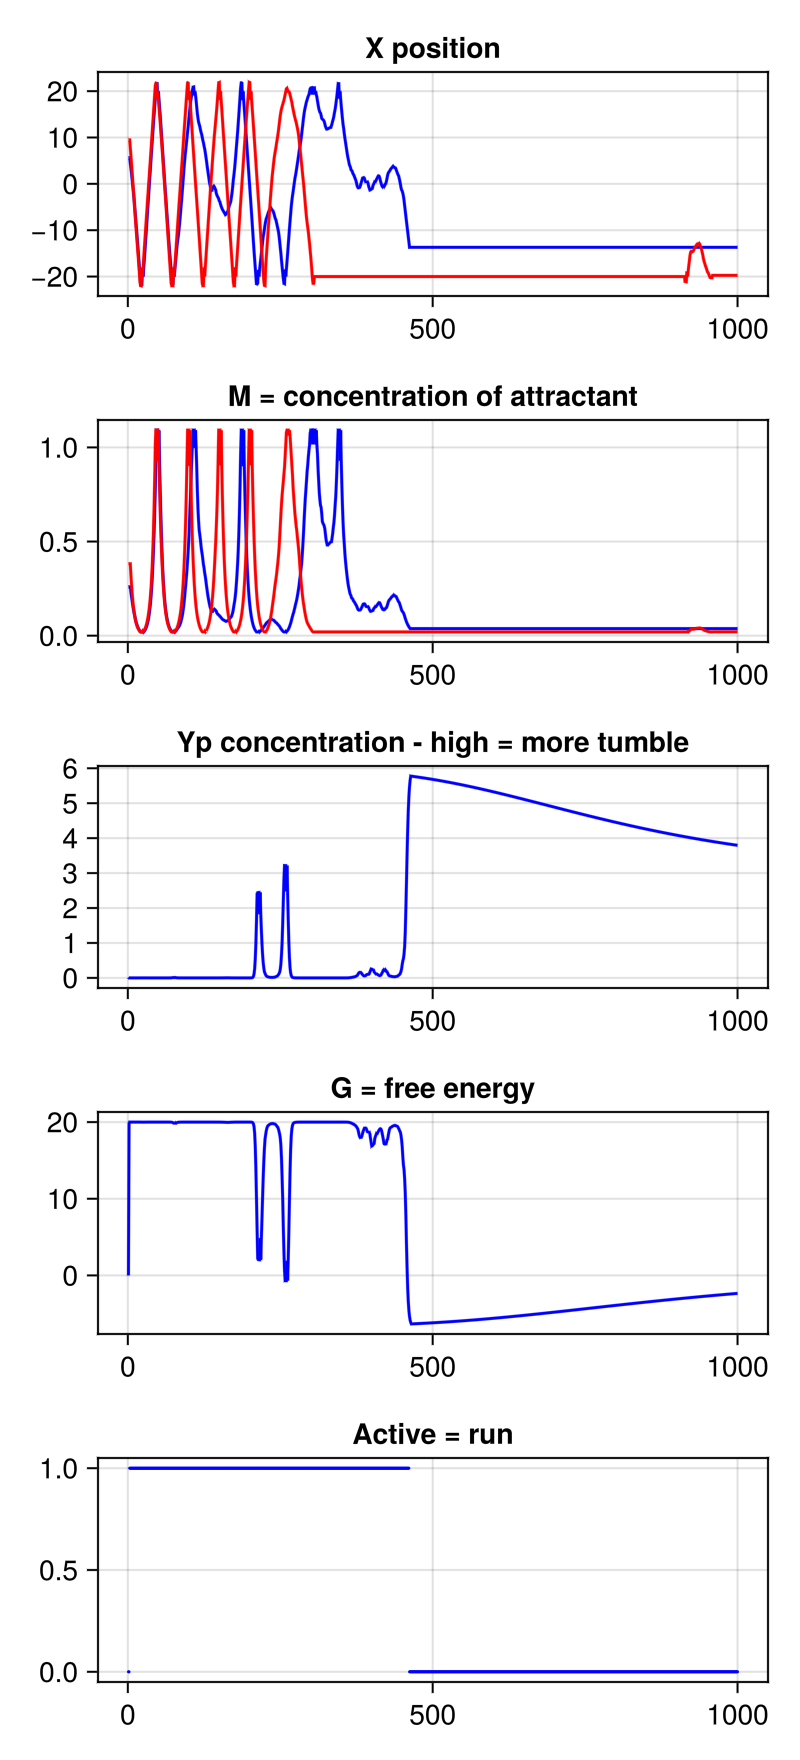

GLMakie.Screen(...)

In [39]:
fig = Figure(size=(400,2800))

ax1 = Axis(fig[1,1], title = "X position")

lines!(ax1, cell1[!, :step], cell1[!, :x], color = :blue)
lines!(ax1, cell2[!, :step], cell2[!, :x], color = :red)

ax0 = Axis(fig[2,1], title = "M = concentration of attractant")

lines!(ax0, cell1[!,:step], cell1[!, :M], color = :blue)
lines!(ax0, cell2[!,:step], cell2[!, :M], color = :red)

ax = Axis(fig[3,1], title = "Yp concentration - high = more tumble")

lines!(ax, cell1[!,:step], cell1[!, :Yp], color = :blue)

ax2 = Axis(fig[4,1], title = "G = free energy")

lines!(ax2, cell1[!, :step], cell1[!, :G], color = :blue)

# ax3 = Axis(fig[5,1], title = "Lambda = run tumble rate")

# scatter!(ax3, cell1[!, :step] ,cell1[!, :λ], color = :blue, markersize = 2)

ax4 = Axis(fig[5,1], title = "Active = run")

scatter!(ax4, cell1[!, :step], cell1[!,:active], color = :blue, markersize = 2)

# ax5 = Axis(fig[6,1], title = "P = 0 - 1")

# scatter!(ax5, cell1[!, :step],cell1[!, :P], color = :blue, markersize = 2)

display(fig)


In [45]:
save("test3.png", fig)

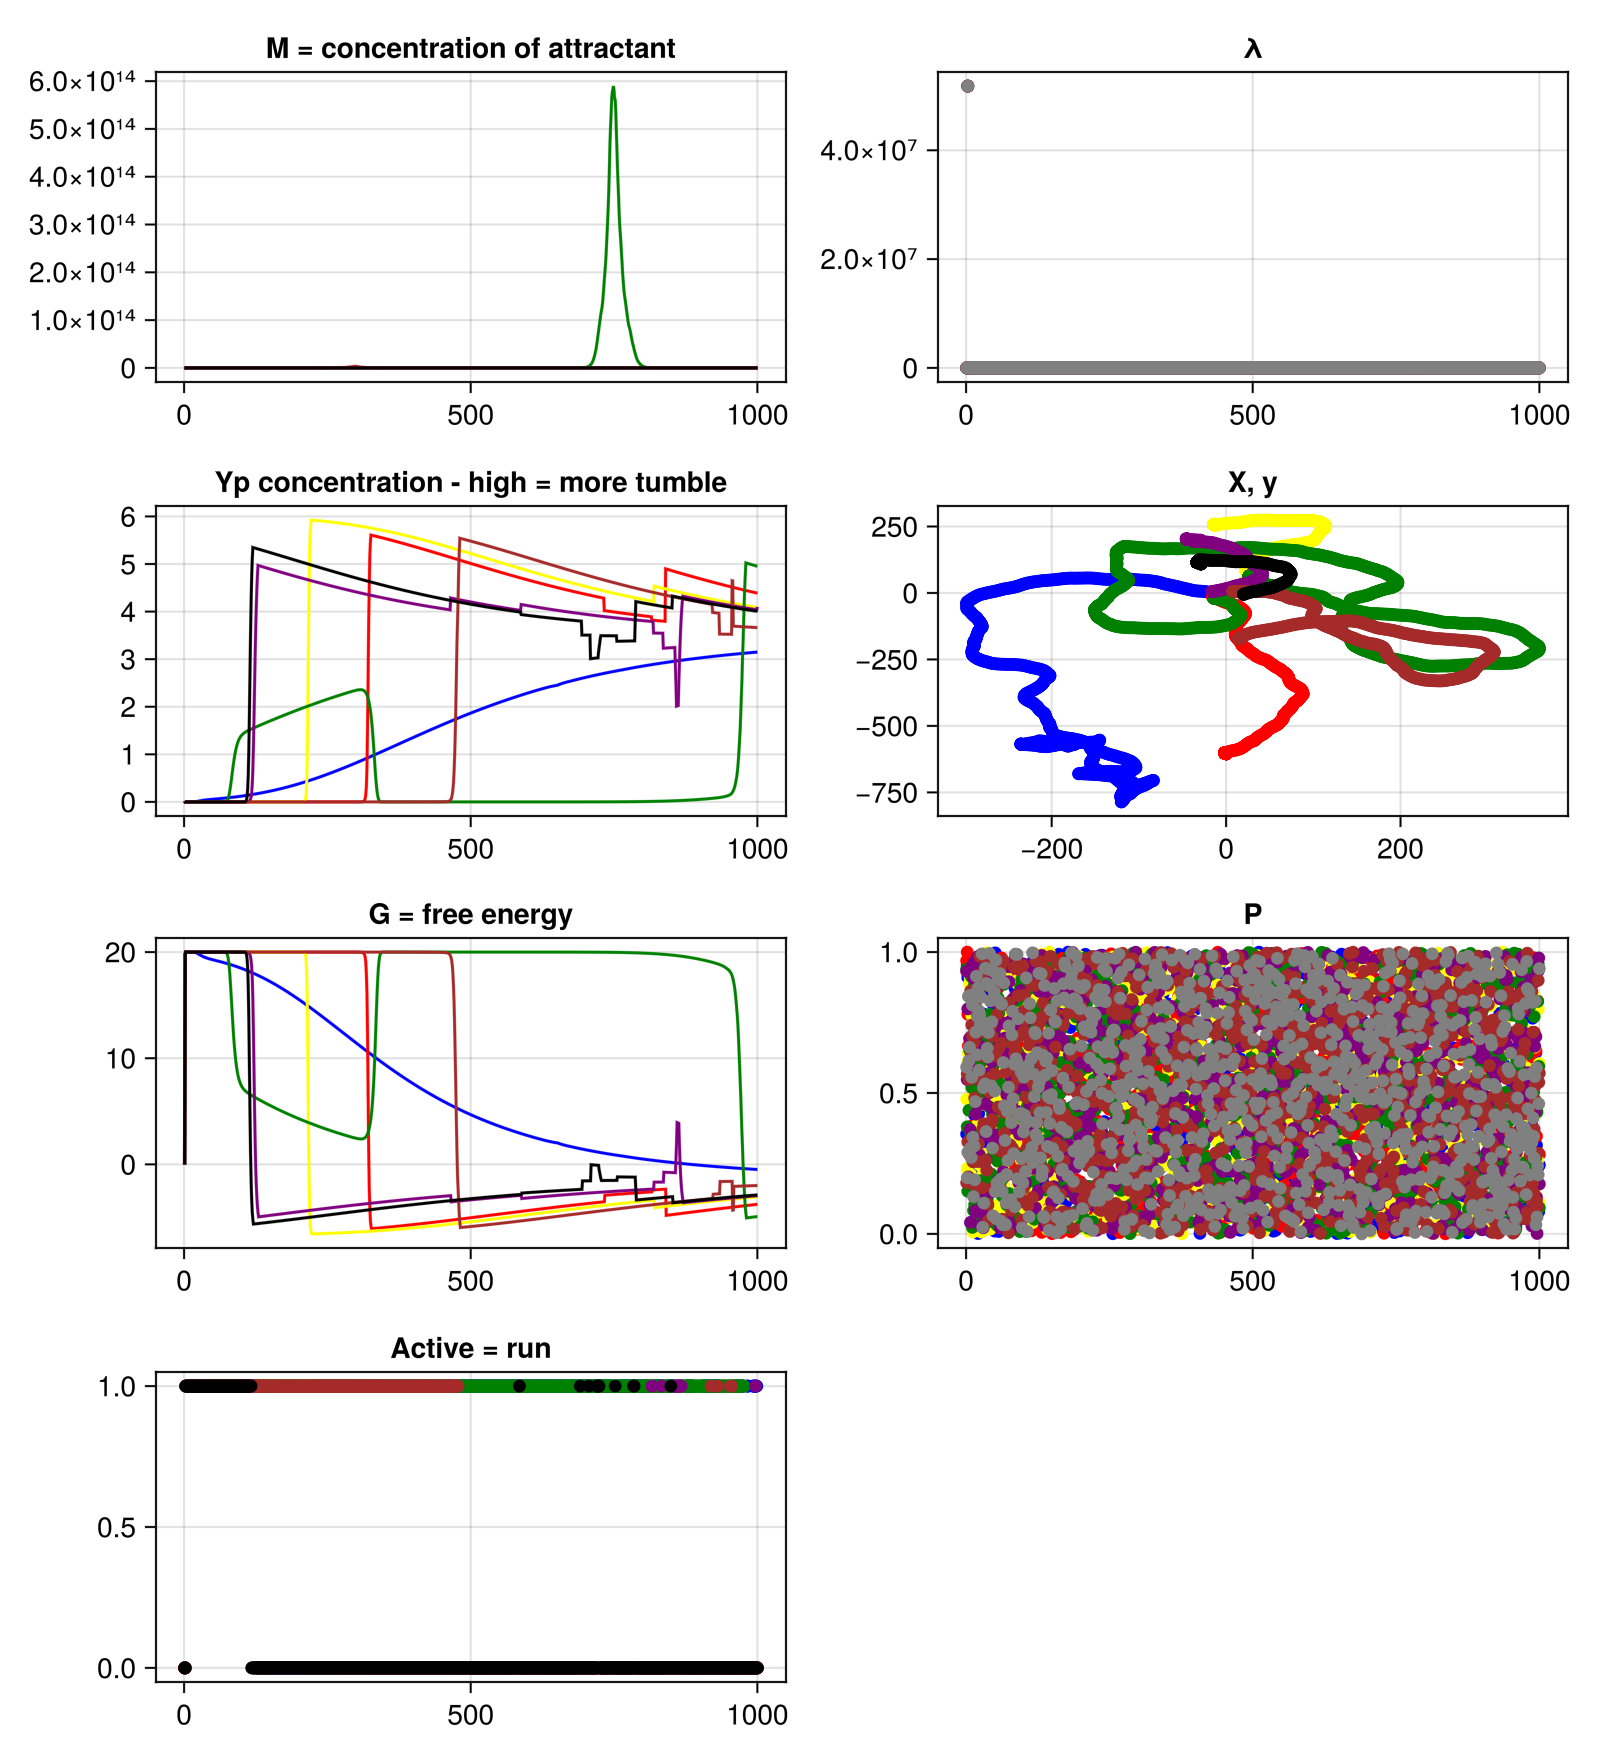

GLMakie.Screen(...)

In [88]:
fig = Figure(size=(800,2500))

ax0 = Axis(fig[1,1], title = "M = concentration of attractant")

lines!(ax0, cell1[!,:step], cell1[!, :M], color = :blue)
lines!(ax0, cell2[!,:step], cell2[!, :M], color = :red)
lines!(ax0, cell3[!,:step], cell3[!, :M], color = :yellow)
lines!(ax0, cell4[!,:step], cell4[!, :M], color = :green)
lines!(ax0, cell5[!,:step], cell5[!, :M], color = :purple)
lines!(ax0, cell6[!,:step], cell6[!, :M], color = :brown)
lines!(ax0, cell7[!,:step], cell7[!, :M], color = :black)

ax = Axis(fig[2,1], title = "Yp concentration - high = more tumble")

lines!(ax, cell1[!,:step], cell1[!, :Yp], color = :blue)
lines!(ax, cell2[!,:step], cell2[!, :Yp], color = :red)
lines!(ax, cell3[!,:step], cell3[!, :Yp], color = :yellow)
lines!(ax, cell4[!,:step], cell4[!, :Yp], color = :green)
lines!(ax, cell5[!,:step], cell5[!, :Yp], color = :purple)
lines!(ax, cell6[!,:step], cell6[!, :Yp], color = :brown)
lines!(ax, cell7[!,:step], cell7[!, :Yp], color = :black)

ax2 = Axis(fig[3,1], title = "G = free energy")

lines!(ax2, cell1[!, :step], cell1[!, :G], color = :blue)
lines!(ax2, cell2[!,:step], cell2[!, :G], color = :red)
lines!(ax2, cell3[!,:step], cell3[!, :G], color = :yellow)
lines!(ax2, cell4[!,:step], cell4[!, :G], color = :green)
lines!(ax2, cell5[!,:step], cell5[!, :G], color = :purple)
lines!(ax2, cell6[!,:step], cell6[!, :G], color = :brown)
lines!(ax2, cell7[!,:step], cell7[!, :G], color = :black)


ax4 = Axis(fig[4,1], title = "Active = run")

scatter!(ax4, cell1[!, :step], cell1[!,:active], color = :blue)
scatter!(ax4, cell2[!,:step], cell2[!, :active], color = :red)
scatter!(ax4, cell3[!,:step], cell3[!, :active], color = :yellow)
scatter!(ax4, cell4[!,:step], cell4[!, :active], color = :green)
scatter!(ax4, cell5[!,:step], cell5[!, :active], color = :purple)
scatter!(ax4, cell6[!,:step], cell6[!, :active], color = :brown)
scatter!(ax4, cell7[!,:step], cell7[!, :active], color = :black)

ax5 = Axis(fig[1, 2], title = "λ")

scatter!(ax5, cell1[!, :step],cell1[!, :λ], color = :blue)
scatter!(ax5, cell2[!,:step], cell2[!, :λ], color = :red)
scatter!(ax5, cell3[!,:step], cell3[!, :λ], color = :yellow)
scatter!(ax5, cell4[!,:step], cell4[!, :λ], color = :green)
scatter!(ax5, cell5[!,:step], cell5[!, :λ], color = :purple)
scatter!(ax5, cell6[!,:step], cell6[!, :λ], color = :brown)
scatter!(ax5, cell7[!,:step], cell7[!, :λ], color = :grey)

ax3 = Axis(fig[2,2], title = "X, y")

scatter!(ax3, cell1[!, :x] ,cell1[!, :y], color = :blue)
scatter!(ax3, cell2[!,:x], cell2[!, :y], color = :red)
scatter!(ax3, cell3[!,:x], cell3[!, :y], color = :yellow)
scatter!(ax3, cell4[!,:x], cell4[!, :y], color = :green)
scatter!(ax3, cell5[!,:x], cell5[!, :y], color = :purple)
scatter!(ax3, cell6[!,:x], cell6[!, :y], color = :brown)
scatter!(ax3, cell7[!,:x], cell7[!, :y], color = :black)

ax6 = Axis(fig[3,2], title = "P")

scatter!(ax6, cell1[!, :step],cell1[!, :P], color = :blue)
scatter!(ax6, cell2[!,:step], cell2[!, :P], color = :red)
scatter!(ax6, cell3[!,:step], cell3[!, :P], color = :yellow)
scatter!(ax6, cell4[!,:step], cell4[!, :P], color = :green)
scatter!(ax6, cell5[!,:step], cell5[!, :P], color = :purple)
scatter!(ax6, cell6[!,:step], cell6[!, :P], color = :brown)
scatter!(ax6, cell7[!,:step], cell7[!, :P], color = :grey)

display(fig)


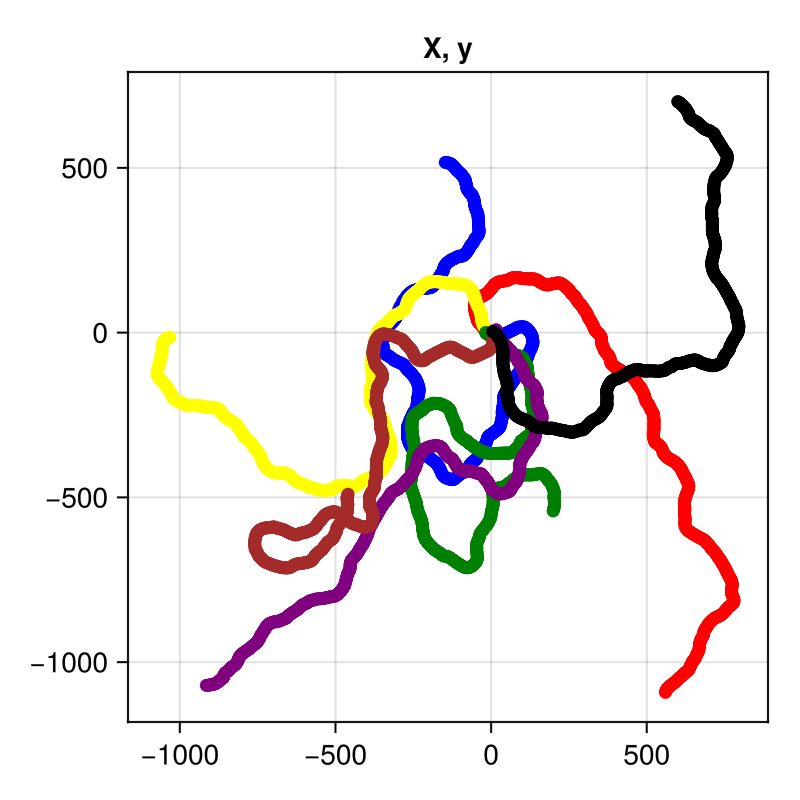

GLMakie.Screen(...)

In [53]:
fig2 = Figure(size= (400,400))
ax3 = Axis(fig2[1,1], title = "X, y")

scatter!(ax3, cell1[!, :x] ,cell1[!, :y], color = :blue)
scatter!(ax3, cell2[!,:x], cell2[!, :y], color = :red)
scatter!(ax3, cell3[!,:x], cell3[!, :y], color = :yellow)
scatter!(ax3, cell4[!,:x], cell4[!, :y], color = :green)
scatter!(ax3, cell5[!,:x], cell5[!, :y], color = :purple)
scatter!(ax3, cell6[!,:x], cell6[!, :y], color = :brown)
scatter!(ax3, cell7[!,:x], cell7[!, :y], color = :black)

display(fig2)

In [13]:
using CSV, DataFrames

data = CSV.read("trajectory.csv", DataFrame)

data_2 = CSV.read("trajectory2.csv", DataFrame)

data_3 = CSV.read("trajectory3.csv", DataFrame)

Row,step,id,x,y,active,λ,G,P,M,Yp
,Int64,Int64,Float64,Float64,Bool,Float64,Float64,Float64,Float64,Float64
1,1,1,-662.335,662.936,false,0.13,0.0,0.0,0.0,0.0148357
2,1,2,1855.61,1714.87,false,0.13,0.0,0.0,0.0,0.0148357
3,1,3,-1510.21,1419.33,false,0.13,0.0,0.0,0.0,0.0148357
4,1,4,5.58719,328.423,false,0.13,0.0,0.0,0.0,0.0148357
5,1,5,654.954,-476.939,false,0.13,0.0,0.0,0.0,0.0148357
6,1,6,-1134.68,1976.66,false,0.13,0.0,0.0,0.0,0.0148357
7,1,7,176.791,1042.34,false,0.13,0.0,0.0,0.0,0.0148357
8,1,8,288.075,940.913,false,0.13,0.0,0.0,0.0,0.0148357
9,1,9,527.031,1967.43,false,0.13,0.0,0.0,0.0,0.0148357
